In [4]:
from pathlib import Path
import pygimli as pg  
from pygimli.physics import ert
import matplotlib.pyplot as plt
from datetime import datetime
import os
import numpy as np

from Hilfsfunktionen import T_corr_nach_Inversion
from Hilfsfunktionen import plotting_function

# Read data
base_dir = Path("filtered_data")
data = []
for unterordner in base_dir.iterdir():
    if unterordner.is_dir():
        datei_pfad = unterordner / "two_timesteps.ohm"
        if datei_pfad.exists():
            daten_objekt = pg.load(str(datei_pfad))
            data.append([unterordner.name, daten_objekt])
            print(f"Load data: {datei_pfad}")

# Create method manager
manager = []
for ts in data:
    manager.append(ert.ERTManager(ts[1], verbose=True))

# Create mesh
mesh = manager[0].createMesh(quality = 34, paraMaxCellSize=0.5, paraDepth=15)

# Inversion without temperature correction
results_tl = []
manager_list_tl = []
chi2_oT = []
chi2_wT = []
chi2 = []
lam=100
for mgr,mgr_number in zip(manager, range(len(manager))):
    print(mgr_number)
    if mgr_number == 1:
        dat = mgr.data
        dataD = dat.copy()
        dataD["rhoa"] = dat["rhoa"] * manager[mgr_number-1].inv.response / manager[mgr_number-1].inv.dataVals
        manager_list_tl.append(ert.Manager(dataD))
        results_tl.append(manager_list_tl[mgr_number].invert(manager_list_tl[mgr_number].data, quality=34,paraMaxCellSize=0.5,
                    paraDepth=15,lam=lam, dPhi= 0.1, startModel=results_tl[0], isReference = True, verbose = True))
        chi2.append(round(manager_list_tl[mgr_number].inv.chi2(),2))
    if mgr_number == 0:
        manager_list_tl.append(mgr)
        results_tl.append(mgr.invert(mgr.data, quality=34,paraMaxCellSize=0.5, 
                                     dPhi= 0.1, paraDepth=15,lam=20, verbose= True)) 
        chi2.append(round(mgr.inv.chi2(),2))
        chi2_oT.append(chi2)


# Temperature correction
results_tl_corr = [] 
temp_spread = []
timestep = 0
ort_2 = 'Langer-Kamp'
mesh2 = manager[0].mesh.createSubMesh(manager[0].mesh.cells(manager[0].mesh.cellMarkers() == 2))
for count, m in enumerate(results_tl):
    timestep = count + 11
    dateien = os.listdir(".\Temperature_data/" + ort )
    
    for datei in dateien: 
        if (datei).startswith('T_Profil%s_array' % (str(timestep))):
            Temp_tiefe_vektor = np.load(".\Temperature_data/" + ort + '/' + datei, allow_pickle=True)
    res_new,Tem_new = T_corr_nach_Inversion(m, mesh2, Temp_tiefe_vektor)
    results_tl_corr.append(res_new)
    
for resu, resu_corr, man, wen in zip(results_tl,results_tl_corr,manager_list_tl, data):
    response = man.inv.fop.response(resu)
    response_t_corr = man.inv.fop.response(resu_corr)
    difference = response_t_corr - response
    wen[1]['rhoa'] = wen[1]['rhoa'] + difference
    
    
# Inversion with temperature correction
results_tl_Tcorr = []
manager_list_tl = []
chi2 = []
for mgr,mgr_number in zip(manager, range(len(manager))):
    print(mgr_number)
    if mgr_number == 1:
        dat = mgr.data
        dataD = dat.copy()
        dataD["rhoa"] = dat["rhoa"] * manager[mgr_number-1].inv.response / manager[mgr_number-1].inv.dataVals
        manager_list_tl.append(ert.Manager(dataD))
        results_tl_Tcorr.append(manager_list_tl[mgr_number].invert(manager_list_tl[mgr_number].data, quality=34,paraMaxCellSize=0.5,
                    paraDepth=15,lam=lam, dPhi= 0.1, startModel=results_tl_Tcorr[0], isReference = True, verbose = True))
        chi2.append(round(manager_list_tl[mgr_number].inv.chi2(),2))
    if mgr_number == 0:
        manager_list_tl.append(mgr)
        results_tl_Tcorr.append(mgr.invert(mgr.data, quality=34,paraMaxCellSize=0.5, 
                                     dPhi= 0.1, paraDepth=15,lam=20, verbose= True)) 
        chi2.append(round(mgr.inv.chi2(),2))
        chi2_wT.append(chi2)


Load data: filtered_data\240610\two_timesteps.ohm
Load data: filtered_data\240704\two_timesteps.ohm


24/04/25 - 19:16:11 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 19:16:11 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 19:16:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 19:16:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


0


24/04/25 - 19:16:12 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 19:16:12 - pyGIMLi - INFO - Use median(data values)=107.75
24/04/25 - 19:16:12 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=107.750000/107.750000
24/04/25 - 19:16:12 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000248E5618680>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000248E56189F0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000248E5618A40>
min/max (data): 23.04/1126
min/max (error): 10%/10.04%
min/max (start model): 108/108
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   79.64
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   15.01 (dPhi = 76.24%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    7.29 (dPhi = 37.50%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    6.84 (dPhi = 1.85%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... 

24/04/25 - 19:17:50 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 19:17:50 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 19:17:50 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 19:17:50 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 19:17:50 - pyGIMLi - INFO - Creating forward mesh from region infos.


chi² =    6.84 (dPhi = 0.03%) lam: 20.0
################################################################################
#                Abort criterion reached: dPhi = 0.03 (< 0.1%)                 #
################################################################################
1


24/04/25 - 19:17:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 19:17:50 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 19:17:51 - pyGIMLi - INFO - Starting inversion.
24/04/25 - 19:17:51 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000248D01B31F0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000248D077EC50>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000248E561ACA0>
min/max (data): 15.94/829
min/max (error): 10%/10.05%
min/max (start model): 15.08/2306
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =    4.66
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    3.26 (dPhi = 23.35%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    3.25 (dPhi = 0.09%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.25 (dPhi = 0.00%) lam: 100.0
################################################################################
#                 Abort criterion reached: dPhi = 0.0 (< 0.1%)   

24/04/25 - 19:33:26 - pyGIMLi - INFO - Use median(data values)=81.96684025962607
24/04/25 - 19:33:26 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=81.966840/81.966840
24/04/25 - 19:33:26 - pyGIMLi - INFO - Starting inversion.


0
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000248E5618680>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000248E56189F0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000248E5618A40>
min/max (data): 9.68/1086
min/max (error): 10%/10.04%
min/max (start model): 81.97/81.97
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   97.98
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   21.23 (dPhi = 73.81%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   11.39 (dPhi = 35.05%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   10.75 (dPhi = 1.86%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... 

24/04/25 - 19:34:14 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 19:34:14 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 19:34:14 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 19:34:14 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 19:34:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 19:34:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


chi² =   10.74 (dPhi = 0.05%) lam: 20.0
################################################################################
#                Abort criterion reached: dPhi = 0.05 (< 0.1%)                 #
################################################################################
1


24/04/25 - 19:34:14 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 19:34:15 - pyGIMLi - INFO - Starting inversion.
24/04/25 - 19:34:15 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000248E51968E0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000248E52B8AE0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000248E52B8310>
min/max (data): 7.82/694
min/max (error): 10%/10.05%
min/max (start model): 8.13/2283
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =    7.38
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    5.83 (dPhi = 15.32%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.83 (dPhi = 0.06%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.83 (dPhi = 0.00%) lam: 100.0
################################################################################
#                 Abort criterion reached: dPhi = 0.0 (< 0.1%)     

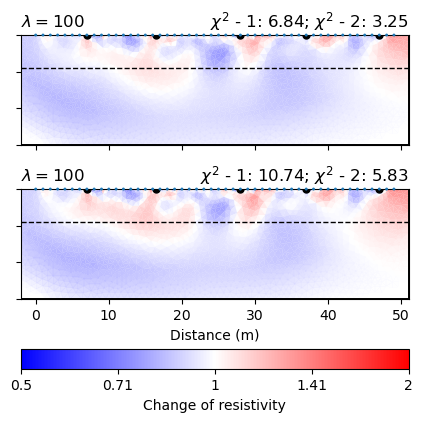

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,6))
axs = axs.flatten()
plt.subplots_adjust(hspace=-0.5)
for nr, chi2, m, name in zip([0,1],[chi2_oT, chi2_wT], [results_tl, results_tl_Tcorr], ['withoutTcorr', 'withTcorr']):
    ratio = m[1] / m[0]
    bild2 = manager[0].showResult(model= ratio,coverage = manager[0].coverage(),
            cMin=1/2, cMax=2, cMap= 'bwr', ax= axs[nr], label = 'Change of resistivity', logScale= True)
    if nr < 1:
        cb = bild2[-1]
        cb.remove() 
        axs[nr].xaxis.set_ticklabels([])  # Unterdrückt die x-Achse Labels
    if nr == 1:
        axs[nr].set_xlabel('Distance (m)')
        
    axs[nr].yaxis.set_ticklabels([])  # Unterdrückt die y-Achse Labels
    axs[nr].set_title('$\chi^2$ - 1: '+ str(chi2[0][0]) + '; $\chi^2$ - 2: ' + str(chi2[0][1]), loc = 'right')
    axs[nr].set_title('$\lambda = $'+ str(100), loc = 'left')
    tree_postions = [7, 16.5, 28, 37, 47]
    for x in tree_postions:
        axs[nr].plot(x, 0, '.', markersize=10, color='black')
    axs[nr].set_ylim(-15, 0)
    axs[nr].axhline(y=-4.5, color='k', linewidth = 1,linestyle='--')

fig.savefig('./Fig11/Diff_inversion.png', bbox_inches = 'tight', dpi=300)